# Stock Trading Agent

This project aims to train reinforcement learning agents to trade stocks using historical market data.

The environment simulates a simplified market where, at each time step, the agent receives:
- The number of shares held
- Close price and daily return for each selected company
- The amount of money available

The agent must decide whether to **buy**, **sell**, or **hold** for each stock. 
The goal is to maximize the total portfolio value over time by learning an optimal trading strategy.

# Required Libraries and auxiliary functions

In [1]:
# Required libraries, classes and functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from market import market
from RandomAgent import RandomAgent
from MomentumAgent import MomentumAgent
from MonteCarloAgent import MonteCarloAgent
from QLearningAgent import QLearningAgent

In [2]:
def play_episode(agent, market):
    """
    Executes a single trading episode using the specified agent and market environment.
    
    Args:
        agent: Trading agent (MonteCarloAgent, QLearningAgent, etc.)
        market: Market environment instance
        
    Returns:
        float: Final portfolio value at the end of the episode
    """
    state = market.start()
    done = False
    
    while not done:
        action = agent.policy(state)
        next_state, reward, done = market.new_day(action)
        state = next_state
    
    return market.get_episode_value()

In [3]:
def evaluate_stateless_agent(env, agent, episodes=10000):
    """
    Evaluates a stateless agent (like RandomAgent or MomentumAgent) over multiple episodes.
    Resets agent's history/memory at the start of each episode.
    
    Args:
        env: Market environment instance
        agent: Stateless trading agent (RandomAgent, MomentumAgent)
        episodes (int): Number of episodes to evaluate
        
    Returns:
        list: List of total rewards for each episode
    """    
    rewards = []

    for _ in range(episodes):
        state = env.start()
        agent.history = [] if hasattr(agent, "history") else None  # Reset momentum memory if needed
        done = False
        total_reward = 0

        while not done:
            action = agent.policy(state)
            state, reward, done = env.new_day(action)
            total_reward += reward

        rewards.append(total_reward)

    return rewards

# Variable Discretization

To handle the continuous nature of the state space, I will discretize the variables into bins.

This discretization reduces the dimensionality of the state space and makes it feasible to apply tabular Monte Carlo and Q-learning methods effectively.

## Close

In [4]:
np.set_printoptions(precision=5, suppress=True)         # In order to see the values with 5 decimal cases and without scientific notation

In [5]:
# Imagine we have 1 stock with close value 0.1 and other with close value 500

print(np.log(0.1))
print(np.log(500))

-2.3025850929940455
6.214608098422191


In [6]:
print(np.exp(-2.5))
print(np.exp(6.5))

0.0820849986238988
665.1416330443618


In [7]:
log_bins = np.linspace(-2.5, 6.5, 10)
print(log_bins)             # Bin values after transforming close as log(close)
print(np.exp(log_bins))     # Real values

[-2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5]
[  0.08208   0.22313   0.60653   1.64872   4.48169  12.18249  33.11545
  90.01713 244.69193 665.14163]


In [8]:
log_bins = np.linspace(-2.5, 6.5, 20)
print(log_bins)             # Bin values after transforming close as log(close)
print(np.exp(log_bins))     # Real close values

[-2.5     -2.02632 -1.55263 -1.07895 -0.60526 -0.13158  0.34211  0.81579
  1.28947  1.76316  2.23684  2.71053  3.18421  3.65789  4.13158  4.60526
  5.07895  5.55263  6.02632  6.5    ]
[  0.08208   0.13182   0.21169   0.33995   0.54593   0.87671   1.40791
   2.26096   3.63088   5.83082   9.36371  15.03719  24.14822  38.77962
  62.27618 100.0093  160.60491 257.91539 414.18627 665.14163]


In [9]:
log_bins = np.linspace(-2.5, 6.5, 30)
print(log_bins)             # Bin values after transforming close as log(close)
print(np.exp(log_bins))     # Real close values

[-2.5     -2.18966 -1.87931 -1.56897 -1.25862 -0.94828 -0.63793 -0.32759
 -0.01724  0.2931   0.60345  0.91379  1.22414  1.53448  1.84483  2.15517
  2.46552  2.77586  3.08621  3.39655  3.7069   4.01724  4.32759  4.63793
  4.94828  5.25862  5.56897  5.87931  6.18966  6.5    ]
[  0.08208   0.11196   0.1527    0.20826   0.28405   0.38741   0.52838
   0.72066   0.98291   1.34058   1.82841   2.49376   3.40123   4.63893
   6.32701   8.62938  11.76957  16.05246  21.89387  29.86095  40.72722
  55.54766  75.76119 103.33034 140.93177 192.21618 262.16276 357.56256
 487.67791 665.14163]


## Return

In [10]:
print(np.linspace(-0.3, 0.3, 20))

[-0.3     -0.26842 -0.23684 -0.20526 -0.17368 -0.14211 -0.11053 -0.07895
 -0.04737 -0.01579  0.01579  0.04737  0.07895  0.11053  0.14211  0.17368
  0.20526  0.23684  0.26842  0.3    ]


# Monte Carlo Agent

Implemented a first-visit Monte Carlo agent to learn stock trading policies based on full episodes.

The agent explores using an epsilon-greedy policy and updates Q-values using the average return of each (state, action) pair, but only on the **first visit** of that pair in each episode.

In [11]:
env = market(['AAPL', 'MSFT'])
agent_MC = MonteCarloAgent(
    n_actions=len(env.index_actions),
    epsilon=0.5
)

In [12]:
agent_MC.train(env, episodes=1000)
play_episode(agent_MC, env)

16628.234130859382

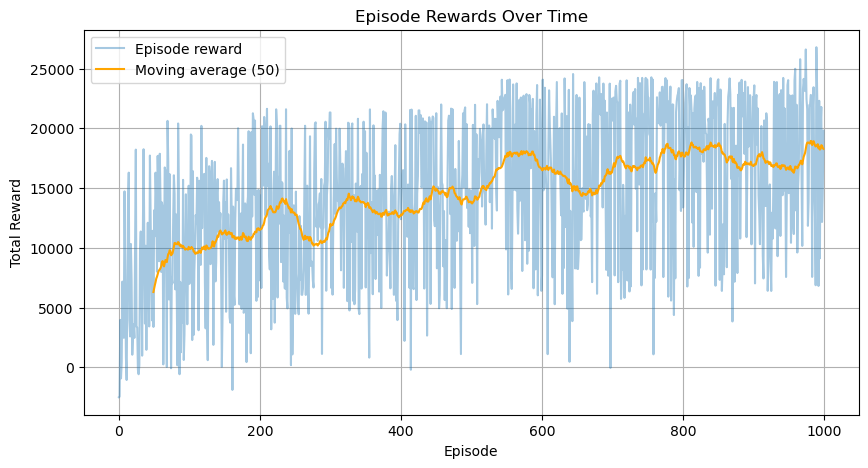

In [13]:
rewards = agent_MC.episode_rewards
episodes = range(len(rewards))
window_size = 50

plt.figure(figsize=(10, 5))
plt.plot(episodes, rewards, alpha=0.4, label="Episode reward")

# Compute moving average
if len(rewards) >= window_size:
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size - 1, len(rewards)), moving_avg, color='orange', label=f"Moving average ({window_size})")

plt.title("Episode Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()

In [14]:
print("Example of 5 last learned states and their Q-values:")
for state_key in list(agent_MC.Q.keys())[:5]:
    print("State:", state_key)
    print("Q-values:", agent_MC.Q[state_key])
    print("Best action:", np.argmax(agent_MC.Q[state_key]))
    print("-" * 80)

Example of 5 last learned states and their Q-values:
State: (0, 0, 25, 10, 23, 10, 5)
Q-values: [10907.66602 10994.15122 13267.45259 11080.74179 10592.73419 10909.05751
 10995.15202 12133.38562 10094.83526]
Best action: 2
--------------------------------------------------------------------------------
State: (0, 0, 25, 9, 23, 9, 5)
Q-values: [11373.13677 13162.97272 13744.03226 14650.44423  9525.77435 12839.76545
  9639.06851 12210.73351 12791.25354]
Best action: 3
--------------------------------------------------------------------------------
State: (57, 0, 25, 10, 23, 11, 1)
Q-values: [  661.45892 13150.71811     0.          0.          0.          0.
     0.          0.          0.     ]
Best action: 1
--------------------------------------------------------------------------------
State: (57, 1, 25, 10, 23, 10, 1)
Q-values: [-2748.13326     0.          0.          0.          0.          0.
     0.          0.          0.     ]
Best action: 1
--------------------------------------

In [15]:
from collections import Counter

best_actions = [int(np.argmax(q)) for q in agent_MC.Q.values()]
counts = Counter(best_actions)

print("Best action distribution across all states:")
for action, count in sorted(counts.items()):
    print(f"Action {action}: {count} states")

Best action distribution across all states:
Action 0: 5743 states
Action 1: 1000 states
Action 2: 439 states
Action 3: 311 states
Action 4: 259 states
Action 5: 267 states
Action 6: 293 states
Action 7: 280 states
Action 8: 278 states


# Q-Learning Agent

The Q-learning agent learns optimal trading actions using the temporal difference (TD) method.

At each step, it updates the Q-table using the formula:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \cdot [r + \gamma \cdot \max_a Q(s', a) - Q(s, a)]
$$

The agent will use an epsilon-greedy policy to balance exploration and exploitation, with epsilon decaying over time.

In [16]:
env = market(['AAPL', 'MSFT'])
agent_QL = QLearningAgent(
    n_actions=len(env.index_actions),
    epsilon=0.5
)

In [17]:
agent_QL.train(env, episodes=1000)
play_episode(agent_QL, env)

18210.88890838623

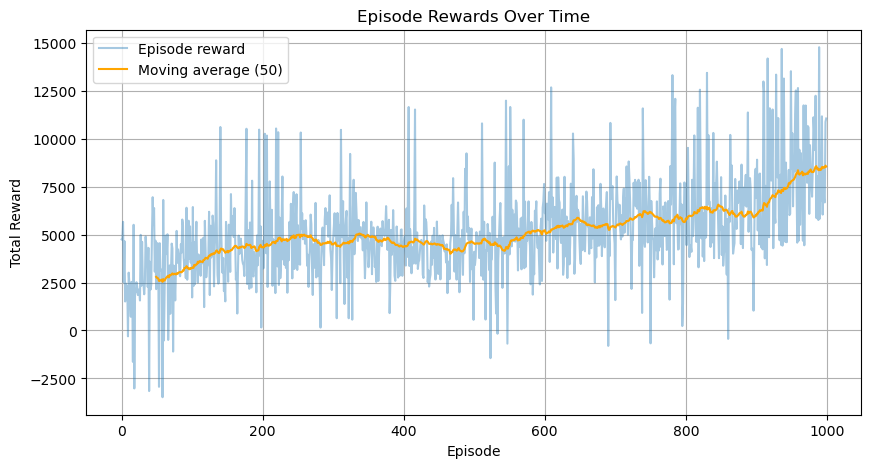

In [18]:
rewards = agent_QL.episode_rewards
episodes = range(len(rewards))
window_size = 50

plt.figure(figsize=(10, 5))
plt.plot(episodes, rewards, alpha=0.4, label="Episode reward")

# Compute moving average
if len(rewards) >= window_size:
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size - 1, len(rewards)), moving_avg, color='orange', label=f"Moving average ({window_size})")

plt.title("Episode Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
print("Example of 5 last learned states and their Q-values:")
for state_key in list(agent_QL.Q.keys())[:-5]:
    print("State:", state_key)
    print("Q-values:", agent_QL.Q[state_key])
    print("Best action:", np.argmax(agent_QL.Q[state_key]))
    print("-" * 85)

Example of 5 last learned states and their Q-values:
State: (0, 0, 25, 11, 23, 11, 5)
Q-values: [105.30102  60.37566  90.0278   89.13882  71.67467  78.42343 104.08248
 194.67127  20.13864]
Best action: 7
-------------------------------------------------------------------------------------
State: (0, 0, 25, 10, 23, 10, 5)
Q-values: [147.64155 139.01573 223.07016 138.5629  144.2837  153.70161 157.50053
 161.9605   23.98368]
Best action: 2
-------------------------------------------------------------------------------------
State: (0, 108, 25, 10, 23, 10, 1)
Q-values: [ 48.72551  95.99524 104.04333  50.63375  74.68829 209.97377  61.32781
 110.14047  89.2785 ]
Best action: 5
-------------------------------------------------------------------------------------
State: (58, 0, 25, 9, 23, 9, 1)
Q-values: [-16.27696  -1.67875  -3.49462 -21.39267 -22.61996 -27.79332 120.25844
   0.        0.     ]
Best action: 6
------------------------------------------------------------------------------------

In [20]:
from collections import Counter

best_actions = [int(np.argmax(q)) for q in agent_QL.Q.values()]
counts = Counter(best_actions)

print("Best action distribution across all states:")
for action, count in sorted(counts.items()):
    print(f"Action {action}: {count} states")

Best action distribution across all states:
Action 0: 3667 states
Action 1: 1163 states
Action 2: 543 states
Action 3: 441 states
Action 4: 286 states
Action 5: 260 states
Action 6: 284 states
Action 7: 236 states
Action 8: 221 states


# Comparing Agents

In [21]:
env = market(['AAPL', 'MSFT', 'TSLA', 'GOOG'])

agents = {}

# Random agent
agents["Random"] = RandomAgent(n_actions=len(env.index_actions))

# Momentum agent
agents["Momentum"] = MomentumAgent(
    n_actions=len(env.index_actions),
    num_companies=env.total_companies,
    window=3
)

# Monte Carlo
agents["MonteCarlo"] = MonteCarloAgent(
    n_actions=len(env.index_actions),
    epsilon=0.5,
)

# Q-learning
agents["QLearning"] = QLearningAgent(
    n_actions=len(env.index_actions),
    epsilon=0.5,
)

In [22]:
agents

{'Random': <RandomAgent.RandomAgent at 0x1ffff7e1ca0>,
 'Momentum': <MomentumAgent.MomentumAgent at 0x1ff8da5bd40>,
 'MonteCarlo': <MonteCarloAgent.MonteCarloAgent at 0x1ff8da5bc80>,
 'QLearning': <QLearningAgent.QLearningAgent at 0x1ff8b3addf0>}

In [23]:
summary = []

for name, agent in agents.items():
    env = market(['AAPL', 'MSFT', 'TSLA', 'GOOG'])

    if name in ["Random", "Momentum"]:
        rewards = evaluate_stateless_agent(env, agent, episodes=20000)
        final_reward = play_episode(agent, env)
    else:
        agent.train(env, episodes=20000)
        rewards = agent.episode_rewards
        agent.epsilon = 0.0
        final_reward = play_episode(agent, env)

    summary.append({
        "Agent": name,
        "Mean Reward": round(np.mean(rewards), 2),
        "Final Portfolio Value": round(final_reward, 2)
    })

df_final = pd.DataFrame(summary).sort_values("Final Portfolio Value", ascending=False)
df_final.reset_index(drop=True, inplace=True)
df_final

,Agent,Mean Reward,Final Portfolio Value
0,MonteCarlo,64023.42,108785.40
1,QLearning,27154.42,51434.01
2,Momentum,2545.73,12771.37
3,Random,4449.23,10536.25


- **Monte Carlo** achieved the best results, both in terms of cumulative reward and final portfolio value.
- **Q-Learning** also performed well, although with lower returns than Monte Carlo. This could be explained by the large state space, which makes Q-Learning require significantly more episodes to properly explore and learn optimal values for all possible states.
- **Momentum** and **Random** agents provided baseline comparisons. Momentum had slightly better intuition than random, but both performed significantly worse than the RL-based approaches.